In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [4]:
# taken from sanbomics package code
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects
import os


def volcano(data, log2fc = 'log2FoldChange', pvalue = 'padj', symbol = 'symbol',
           baseMean = None, 
           pval_thresh = 0.05,
           log2fc_thresh = 0.75,
           to_label = 5, 
           color_dict = None, shape_dict = None,
           fontsize = 10,
           colors = ['dimgrey', 'lightgrey', 'black'],
           top_right_frame = False,
           figsize = (5,5), legend_pos = (1.4,1),
           
           point_sizes = (15,150),
           save = True, 
           shapes = None,
           shape_order = None):
    
    '''
    Make a volcano plot from a pandas dataframe of directly from a csv.
    
    data : pandas.DataFrame or path to csv
    log2fc : string
        column name of log2 Fold-Change values
    pvalue : string
        column name of the p values to be converted to -log10 P values
    symbol : string
        column name of gene IDs to use
    baseMean : string
        column name of base mean values for each gene. If this is passed, 
        the size of the points will vary.
    pval_thresh : numeric
        threshold pvalue for points to be significant. Also controls horizontal
        line.
    log2fc_thresh : numeric
        threshold for the absolute value of the log2 fold change to be considered
        significant. Also controls vertical lines
    to_label : int or list
        If an int is passed, that number of top down and up genes will be labeled.
        If a list of gene Ids is passed, only those will be labeled.
    color_dict : dictionary
        dictionary to color dots by. Up to 11 categories with default colors.
        Pass list of genes and the category to group them by. {category : ['gene1', gene2]}
        Default colors are: ['dimgrey', 'lightgrey', 'tab:blue', 'tab:orange',
        'tab:green', 'tab:red', 'tab:purple','tab:brown', 'tab:pink', 
        'tab:olive', 'tab:cyan']
    shape_dict : dictionary
        dictionary to shape dots by. Up to 6 categories. Pass list of genes as values
        and category as key. {category : ['gene1', gene2], category2 : ['gene3']}
    fontsize : int
        size of labels
    colors : list
        order and colors to use. Default ['dimgrey', 'lightgrey', 'black']
    top_right_frame : Boolean
        Show the top and right frame. True/False
    figsize : tuple
        Size of figure. (x, y)
    point_sizes : tuple
        lower and upper bounds of point sizes. If baseMean is not None.
        (lower, upper)
    save : boolean | string
        If true saves default file name. Pass string as path to output file. Will
        add a .svg/.png to string. Saves as both png and svg.
    shapes : list
        pass matplotlib marker ids to change default shapes/order
        Default shapes order is: ['o', '^', 's', 'X', '*', 'd']
    shape_order : list
        If you want to change the order of categories for your shapes. Pass
        a list of your categories.
    
    '''
    
    
    
    
    if isinstance(data, str):
        df = pd.read_csv(data)
    else: 
        df = data.copy(deep = True)
        
        
    #clean and imput 0s
    df = df.dropna()
    if df[pvalue].min() == 0:
        print('0s encountered for p value, imputing 1e-323')
        print('impute your own value if you want to avoid this')
        df[pvalue][df[pvalue] == 0] = 1e-323
        
        
    
    pval_thresh = -np.log10(pval_thresh) #convert p value threshold to nlog10
    df['nlog10'] = -np.log10(df[pvalue]) #make nlog10 column
    df['sorter'] = df['nlog10']*df[log2fc] #make a column to pick top genes
    
    
    #size the dots by basemean if a column id is passed
    if baseMean is not None:
        df['logBaseMean'] = np.log(df[baseMean])
        baseMean = 'logBaseMean'
    else:
        point_sizes = None
    
    
    #color dots by {label:[list of genes]}
    
    
    
    
    #make label list of top x genes up and down, or based on list input
    if isinstance(to_label, int):
        label_df = pd.concat(
        (df.sort_values('sorter')[-to_label:],
        df.sort_values('sorter')[0:to_label]))
        
    else:
        label_df = df[df[symbol].isin(to_label)]
        
        
        

    
    #color light grey if below thresh, color picked black
    def map_color_simple(a):
        log2FoldChange, zymbol, nlog10 = a
        if zymbol in label_df[symbol].tolist():
            return 'picked'
            
        if abs(log2FoldChange) < log2fc_thresh or nlog10 < pval_thresh:
            return 'not DE'
        return 'DE'
    
    if color_dict is None:
        df['color'] = df['color'] = df[[log2fc, symbol, 'nlog10']].apply(map_color_simple, axis = 1)
        hues = ['DE', 'not DE', 'picked'][:len(df.color.unique())] #order of colors
    
    #coloring if dictionary passed
    def map_color_complex(a):
        log2FoldChange, zymbol, nlog10 = a
        
        for k in list(color_dict):
            if zymbol in color_dict[k]:
                return k
        if abs(log2FoldChange) < log2fc_thresh or nlog10 < pval_thresh:
            return 'not DE'
        return 'DE'
    
    if color_dict is not None:
        df['color'] = df['color'] = df[[log2fc, symbol, 'nlog10']].apply(map_color_complex, axis = 1)
        user_added_cats = [x for x in df.color.unique() if x not in ['DE', 'not DE']]
        hues = ['DE', 'not DE'] + user_added_cats
        hues = hues[:len(df.color.unique())] #order of colors
        if colors == ['dimgrey', 'lightgrey', 'black']:
            colors = ['dimgrey', 'lightgrey', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
                     'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']
            
            
    #map shapes if dictionary exists
    def map_shape(zymbol):
        for k in list(shape_dict):
            if zymbol in shape_dict[k]:
                return k

        return 'other'
            
    if shape_dict is not None:
        df['shape'] =  df[symbol].map(map_shape)
        user_added_cats = [x for x in df['shape'].unique() if x  != 'other']
        shape_order = ['other'] + user_added_cats
        if shapes is None:
            shapes = ['o', '^', 's', 'X', '*', 'd']
        shapes = shapes[:len(df['shape'].unique())]
        shape_col = 'shape'
    else:
        shape_col = None
    
    
    

    #build palette
    colors = colors[:len(df.color.unique())]

    
    
    plt.figure(figsize = figsize)
    ax = sns.scatterplot(data = df, x = log2fc, y = 'nlog10',                 
                hue = 'color', hue_order = hues, palette = colors,
                        size = baseMean, sizes = point_sizes, 
                        style = shape_col, style_order = shape_order, markers = shapes)
    

    
    
    #make labels
    texts = []
    for i in range(len(label_df)):
        
        txt = plt.text(x = label_df.iloc[i][log2fc],
                              y = label_df.iloc[i].nlog10,
                              s = label_df.iloc[i][symbol],
                              fontsize = fontsize,
                              weight = 'bold')
        
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        texts.append(txt)
    adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k', zorder = 5))
    
    
    
    
    
    #plot vertical and horizontal lines
    ax.axhline(pval_thresh, zorder = 0, c = 'k', lw = 2, ls = '--')
    ax.axvline(log2fc_thresh, zorder = 0, c = 'k', lw = 2, ls = '--')
    ax.axvline(log2fc_thresh * -1, zorder = 0, c = 'k', lw = 2, ls = '--')
    
    
    
    #make things pretty
    for axis in ['bottom', 'left', 'top', 'right']:
        ax.spines[axis].set_linewidth(2)
        
    if not top_right_frame:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    ax.tick_params(width = 2)
    plt.xticks(size = 11, weight = 'bold')
    plt.yticks(size = 11, weight = 'bold')
    plt.xlabel("$log_{2}$ fold change", size = 15)
    plt.ylabel("-$log_{10}$ FDR", size = 15)
    
    plt.legend(loc = 1, bbox_to_anchor = legend_pos, frameon = False, prop = {'weight':'bold'})
    
    if save == True:
        files = os.listdir()
        for x in range(100):
            file_pref = "volcano_" + "%02d" % (x,)
            if len([x for x in files if x.startswith(file_pref)]) == 0:
                plt.savefig(file_pref + '.png', dpi = 300, bbox_inches = 'tight')
                plt.savefig(file_pref + '.svg', bbox_inches = 'tight')
                break
    elif isinstance(save, str):
        plt.savefig(save + '.png', dpi = 600, bbox_inches = 'tight')    
    plt.show()

In [19]:
gene_list = pd.read_csv('hallmark_surv_curated.csv')
gene_list

,IA,TPI,GIM,SPS,AID,ERI,RCD,EGS,DCE,AIM
0,CCR3,PLCB2,BLM,PAK2,HCST,E2F1,PAK2,PAK2,PRKAG3,CDH15
1,HIF1A,PRKCG,FANCI,GNG3,HIF1A,PIK3CD,IL6R,GNG3,NFE2L2,PAK2
2,PRKCG,TNFAIP3,RECQL4,IL6R,PLCB2,NRAS,PLK1,RBL1,GPI,PLCB2
3,MMP1,CARD11,POLD3,PLCB2,CXCR1,PIK3CG,ELK1,FZD2,HIF1A,FZD2
4,PIK3CD,GNB1,PCNA,PKN3,CCL26,PRKCA,BCL6,WNT3A,PFKP,WNT3A
...,...,...,...,...,...,...,...,...,...,...
202,NaN,NaN,NaN,PIM1,NaN,NaN,NaN,NaN,NaN,NaN
203,NaN,NaN,NaN,CSF3,NaN,NaN,NaN,NaN,NaN,NaN
204,NaN,NaN,NaN,BARD1,NaN,NaN,NaN,NaN,NaN,NaN
205,NaN,NaN,NaN,GNA12,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
meta_neg = pd.read_csv('meta_neg_sep_hallmark.csv', index_col=(0))
meta_neg['sample'] = meta_neg.index.str.split('&').str[0]
meta_neg.index = [f'Negative_{j+1}' for j in range(len(meta_neg.index))]
meta_neg['Class'] = 0
meta_neg

,Cancer,Hallmark,sample,Class
Negative_1,Ovarian,AID,1,0
Negative_2,Breast,AID,1,0
Negative_3,Ovarian,AID,1,0
Negative_4,Prostate,AIM,1,0
Negative_5,Prostate,AIM,1,0
...,...,...,...,...
Negative_39139,Hematologic,ERI,tFL1,0
Negative_39140,Hematologic,IA,tFL1,0
Negative_39141,Hematologic,IA,tFL1,0
Negative_39142,Hematologic,ERI,tFL2,0


In [7]:
meta_pos = pd.read_csv('meta_pos_sep_hallmark.csv', index_col=(0))
meta_pos['sample'] = meta_pos.index.str.split('&').str[0]
meta_pos.index = [f'Positive_{j+1}' for j in range(len(meta_pos.index))]
meta_pos['Class'] = 1
meta_pos

,Cancer,Hallmark,sample,Class
Positive_1,Ovarian,AIM,1,1
Positive_2,Ovarian,AIM,1,1
Positive_3,Ovarian,AIM,1,1
Positive_4,Ovarian,AIM,1,1
Positive_5,Ovarian,AIM,1,1
...,...,...,...,...
Positive_28783,Hematologic,EGS,tFL2,1
Positive_28784,Hematologic,ERI,tFL2,1
Positive_28785,Hematologic,ERI,tFL2,1
Positive_28786,Hematologic,IA,tFL2,1


In [8]:
data_pos = pd.read_csv('data_pos_sep_hallmark.csv',index_col=(0))
data_pos.index = [f'Positive_{j+1}' for j in range(len(data_pos.index))]
data_pos

,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,B3GALT6,UBE2J2,ACAP3,...,AP000676.5,SNHG29,AC090498.1,LRRC75A-AS1,MTCO2P12,C19ORF43,C14ORF2,UQCR11.1,COX1,COX2
Positive_1,91,213,229,12,6,25,119,70,108,8,...,0,0,0,0,0,0,0,0,0,0
Positive_2,109,186,132,15,9,7,132,87,116,11,...,0,0,0,0,0,0,0,0,0,0
Positive_3,125,206,125,22,14,22,154,100,126,14,...,0,0,0,0,0,0,0,0,0,0
Positive_4,112,167,177,20,8,11,145,101,121,13,...,0,0,0,0,0,0,0,0,0,0
Positive_5,109,234,159,15,10,23,141,56,120,10,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Positive_28783,18,3,26,0,20,35,41,4,31,3,...,0,0,0,0,0,0,0,0,0,0
Positive_28784,16,0,13,1,0,0,24,3,23,2,...,0,0,0,0,0,0,0,0,0,0
Positive_28785,29,0,19,0,0,5,32,3,30,2,...,0,0,0,0,0,0,0,0,0,0
Positive_28786,25,0,22,0,8,17,27,3,30,4,...,0,0,0,0,0,0,0,0,0,0


In [9]:
data_neg = pd.read_csv('data_neg_sep_hallmark.csv',index_col=(0))
data_neg.index = [f'Negative_{j+1}' for j in range(len(data_neg.index))]
data_neg

,SAMD11,NOC2L,HES4,ISG15,AGRN,TNFRSF18,TNFRSF4,SDF4,B3GALT6,C1QTNF12,...,PPP1R2C,AC073111.5,AL117339.5,MTCO2P12,MT-RNR1,MT-RNR2,COX1,COX2,COX3,ND4
Negative_1,3,39,66,63,5,3,1,47,22,0,...,0,0,0,0,0,0,0,0,0,0
Negative_2,0,6,5,201,0,65,139,8,0,0,...,0,0,0,0,0,0,0,0,0,0
Negative_3,11,34,79,41,5,6,10,54,13,3,...,0,0,0,0,0,0,0,0,0,0
Negative_4,1,14,36,27,1,0,0,33,4,0,...,0,0,0,0,0,0,0,0,0,0
Negative_5,0,9,35,29,3,0,1,29,3,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Negative_39139,0,12,4,76,0,17,37,14,6,0,...,0,0,0,0,0,0,0,0,0,0
Negative_39140,1,9,2,71,0,11,9,12,2,0,...,0,0,0,0,0,0,0,0,0,0
Negative_39141,0,3,2,129,3,25,34,24,8,0,...,0,0,0,0,0,0,0,0,0,0
Negative_39142,0,22,0,33,0,29,33,33,2,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
common = (list(set(data_pos.columns) & set(data_neg.columns)))
len(common)

9326

In [11]:
data_pos1 = data_pos[common]
data_pos1

,EDF1,ALDH3A2,NDUFS5,ARHGAP30,EEF1AKMT4,ATP5MF,POP7,PSMD14,FHL2,LDHA,...,GMEB2,WASHC2A,C1orf210,MAL,TDO2,CCDC57,DIP2C,SPRYD4,YWHAE,HLA-DOA
Positive_1,508,52,420,8,5,122,74,257,203,964,...,18,8,2,1,0,19,31,11,486,0
Positive_2,515,25,430,8,12,91,92,255,215,953,...,25,17,1,1,0,16,38,17,586,3
Positive_3,531,51,521,4,18,113,81,310,175,1026,...,27,13,5,0,2,22,32,23,673,1
Positive_4,563,53,444,10,14,110,62,277,218,950,...,28,21,2,1,1,22,35,19,539,0
Positive_5,571,39,461,7,14,103,103,285,189,1093,...,20,24,1,1,7,23,36,9,611,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Positive_28783,165,1,93,43,0,124,9,28,1,110,...,3,5,0,18,0,7,3,3,73,20
Positive_28784,159,0,59,50,0,130,7,22,3,88,...,0,8,0,14,0,8,5,5,62,20
Positive_28785,151,0,67,40,0,122,8,34,0,77,...,2,7,0,2,0,3,3,4,66,35
Positive_28786,169,0,96,67,0,128,17,33,1,135,...,3,6,0,9,0,6,4,3,78,27


In [12]:
data_neg1 = data_neg[common]
data_neg1

,EDF1,ALDH3A2,NDUFS5,ARHGAP30,EEF1AKMT4,ATP5MF,POP7,PSMD14,FHL2,LDHA,...,GMEB2,WASHC2A,C1orf210,MAL,TDO2,CCDC57,DIP2C,SPRYD4,YWHAE,HLA-DOA
Negative_1,166,26,201,3,3,36,31,76,301,266,...,10,4,0,0,0,11,16,3,197,0
Negative_2,71,1,59,12,0,58,4,13,0,98,...,0,1,0,5,0,10,0,3,24,0
Negative_3,167,17,239,1,2,41,43,103,336,287,...,2,3,0,1,0,11,17,5,189,0
Negative_4,151,12,97,0,0,0,14,8,0,24,...,3,0,2,0,0,29,2,9,73,0
Negative_5,122,10,95,0,0,0,13,2,2,7,...,2,0,0,0,0,29,1,7,54,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Negative_39139,102,1,57,30,0,82,7,15,1,99,...,3,8,0,10,0,13,10,1,61,9
Negative_39140,97,1,70,27,0,90,14,15,1,153,...,1,5,0,6,0,14,5,1,59,5
Negative_39141,113,2,80,31,0,109,11,15,0,153,...,2,4,0,10,0,16,14,4,55,9
Negative_39142,162,3,105,68,0,137,14,29,0,101,...,4,4,0,8,0,16,5,3,61,13


In [15]:
hall_list = ['AIM', 'DCE', 'EGS', 'GIM', 'RCD', 'SPS', 'AID', 'IA', 'ERI', 'TPI']

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 1.11 seconds.

Fitting dispersions...
... done in 4.78 seconds.

Fitting dispersion trend curve...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 4.49 seconds.

Fitting LFCs...
... done in 6.44 seconds.

Calculating cook's distance...
... done in 4.40 seconds.

Replacing 334 outlier genes.

Fitting dispersions...
... done in 0.40 seconds.

Fitting MAP dispersions...
... done in 0.41 seconds.

Fitting LFCs...
... done in 2.15 seconds.

Running Wald tests...
... done in 3.18 seconds.



Log2 fold change & Wald test p-value: Class 1 vs 0
             baseMean  log2FoldChange     lfcSE       stat         pvalue  \
EDF1       189.778495       -0.288154  0.019531 -14.753870   2.905179e-49   
ALDH3A2     14.986714       -0.725666  0.025974 -27.937978  9.228341e-172   
NDUFS5     159.025612       -0.395131  0.023813 -16.593402   7.778667e-62   
ARHGAP30    26.220652        2.034979  0.038351  53.062652   0.000000e+00   
EEF1AKMT4    1.495272       -0.697957  0.086389  -8.079201   6.519252e-16   
...               ...             ...       ...        ...            ...   
CCDC57      22.538290       -1.145144  0.028338 -40.410048   0.000000e+00   
DIP2C       39.580939       -4.718856  0.071990 -65.548714   0.000000e+00   
SPRYD4       5.489845       -0.782703  0.025556 -30.626461  5.439821e-206   
YWHAE      104.051162       -0.222610  0.014562 -15.286742   9.372321e-53   
HLA-DOA     10.616026        2.274125  0.047296  48.083256   0.000000e+00   

                    padj

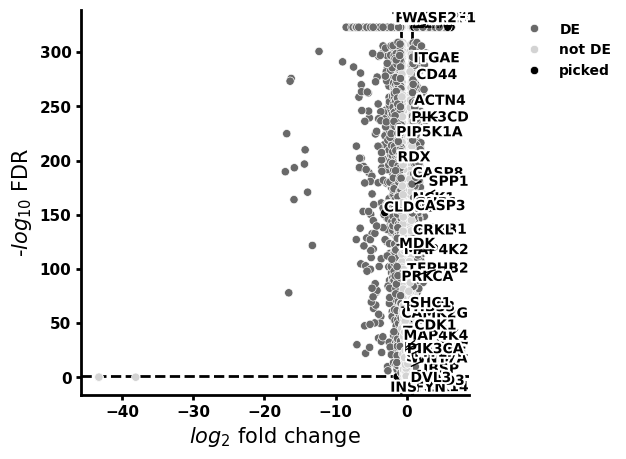

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.84 seconds.

Fitting dispersions...
... done in 6.21 seconds.

Fitting dispersion trend curve...
... done in 0.25 seconds.

Fitting MAP dispersions...
... done in 5.09 seconds.

Fitting LFCs...
... done in 4.95 seconds.

Calculating cook's distance...
... done in 5.27 seconds.

Replacing 284 outlier genes.

Fitting dispersions...
... done in 0.33 seconds.

Fitting MAP dispersions...
... done in 0.25 seconds.

Fitting LFCs...
... done in 1.49 seconds.

Running Wald tests...
... done in 3.43 seconds.



Log2 fold change & Wald test p-value: Class 1 vs 0
             baseMean  log2FoldChange     lfcSE       stat         pvalue  \
EDF1       200.573481        0.349939  0.020229  17.299206   4.769128e-67   
ALDH3A2     15.679584        0.245286  0.026004   9.432454   4.006058e-21   
NDUFS5     172.745715        0.793190  0.024465  32.421823  1.352135e-230   
ARHGAP30    25.483737       -0.460228  0.034858 -13.202793   8.454151e-40   
EEF1AKMT4    2.069932        1.285447  0.092962  13.827628   1.736516e-43   
...               ...             ...       ...        ...            ...   
CCDC57      26.338516       -1.427104  0.026966 -52.923131   0.000000e+00   
DIP2C       61.060850       -5.010115  0.065027 -77.046647   0.000000e+00   
SPRYD4       5.569842        0.232167  0.023973   9.684402   3.512578e-22   
YWHAE      119.164344        0.476065  0.015643  30.433309  1.992158e-203   
HLA-DOA      9.159060        0.004879  0.042153   0.115737   9.078607e-01   

                    padj

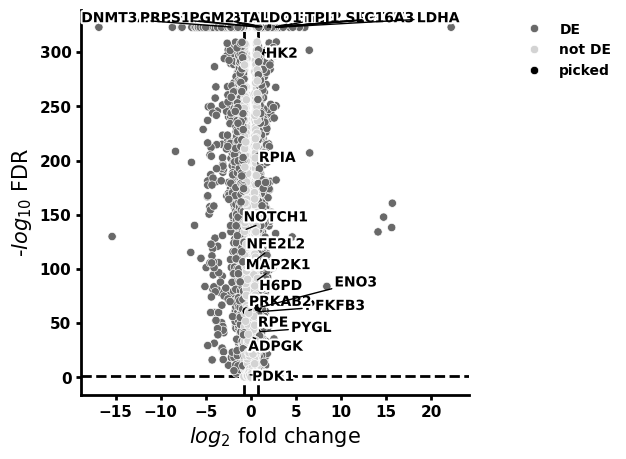

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.73 seconds.

Fitting dispersions...
... done in 4.47 seconds.

Fitting dispersion trend curve...
... done in 0.24 seconds.

Fitting MAP dispersions...
... done in 4.27 seconds.

Fitting LFCs...
... done in 5.00 seconds.

Calculating cook's distance...
... done in 4.00 seconds.

Replacing 335 outlier genes.

Fitting dispersions...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 0.47 seconds.

Fitting LFCs...
... done in 1.65 seconds.

Running Wald tests...
... done in 2.96 seconds.



Log2 fold change & Wald test p-value: Class 1 vs 0
             baseMean  log2FoldChange     lfcSE       stat         pvalue  \
EDF1       192.323476       -0.554063  0.018183 -30.470675  6.377145e-204   
ALDH3A2     15.707513       -1.045552  0.029153 -35.864541  1.091383e-281   
NDUFS5     160.558495       -0.630357  0.022191 -28.406069  1.701586e-177   
ARHGAP30    27.916336        1.239035  0.036457  33.986011  3.585682e-253   
EEF1AKMT4    1.574999       -0.670433  0.088504  -7.575154   3.587017e-14   
...               ...             ...       ...        ...            ...   
CCDC57      21.723593       -0.987683  0.030008 -32.913747  1.397520e-237   
DIP2C       43.078297       -3.710437  0.077816 -47.682127   0.000000e+00   
SPRYD4       5.468618       -1.127342  0.026624 -42.342554   0.000000e+00   
YWHAE      108.262159       -0.345673  0.017595 -19.646309   6.217297e-86   
HLA-DOA     11.345240        1.561962  0.043921  35.563277  5.180134e-277   

                    padj

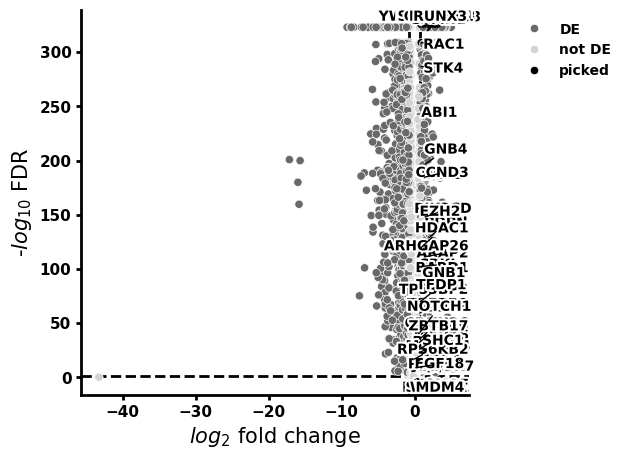

Fitting size factors...
... done in 0.18 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 1.97 seconds.

Fitting dispersion trend curve...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 1.89 seconds.

Fitting LFCs...
... done in 2.09 seconds.

Calculating cook's distance...
... done in 0.97 seconds.

Replacing 403 outlier genes.

Fitting dispersions...
... done in 0.53 seconds.

Fitting MAP dispersions...
... done in 0.51 seconds.

Fitting LFCs...
... done in 0.78 seconds.

Running Wald tests...
... done in 1.35 seconds.



Log2 fold change & Wald test p-value: Class 1 vs 0
             baseMean  log2FoldChange     lfcSE       stat        pvalue  \
EDF1       180.513875       -0.348926  0.025016 -13.948103  3.230863e-44   
ALDH3A2     14.084554       -0.270521  0.055716  -4.855362  1.201671e-06   
NDUFS5     171.275831        0.008149  0.039341   0.207142  8.358993e-01   
ARHGAP30    17.871000        0.547437  0.086472   6.330762  2.439533e-10   
EEF1AKMT4    1.854334        1.804761  0.230457   7.831233  4.831079e-15   
...               ...             ...       ...        ...           ...   
CCDC57      28.869374        0.233422  0.075479   3.092528  1.984596e-03   
DIP2C       31.834653        2.087416  0.137919  15.135036  9.512870e-52   
SPRYD4       5.044167       -0.244609  0.051064  -4.790239  1.665826e-06   
YWHAE      126.160570        0.333842  0.033966   9.828722  8.468622e-23   
HLA-DOA      5.562174       -0.701821  0.096550  -7.269023  3.620964e-13   

                   padj  
EDF1      

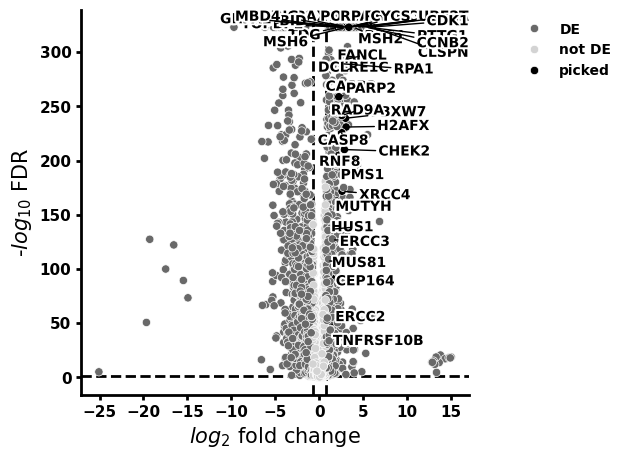

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.59 seconds.

Fitting dispersions...
... done in 3.84 seconds.

Fitting dispersion trend curve...
... done in 0.24 seconds.

Fitting MAP dispersions...
... done in 3.38 seconds.

Fitting LFCs...
... done in 3.43 seconds.

Calculating cook's distance...
... done in 2.77 seconds.

Replacing 396 outlier genes.

Fitting dispersions...
... done in 0.59 seconds.

Fitting MAP dispersions...
... done in 0.48 seconds.

Fitting LFCs...
... done in 1.27 seconds.

Running Wald tests...
... done in 2.72 seconds.



Log2 fold change & Wald test p-value: Class 1 vs 0
             baseMean  log2FoldChange     lfcSE       stat         pvalue  \
EDF1       208.224091       -0.458965  0.020044 -22.897614  4.907588e-116   
ALDH3A2     16.444785       -0.572661  0.031603 -18.120636   2.190488e-73   
NDUFS5     168.774136       -0.473098  0.024367 -19.415463   5.711888e-84   
ARHGAP30    32.191712        0.883617  0.044155  20.011532   4.370055e-89   
EEF1AKMT4    1.735624       -0.841694  0.093586  -8.993830   2.387615e-19   
...               ...             ...       ...        ...            ...   
CCDC57      22.632800       -1.125639  0.034648 -32.487687  1.591452e-231   
DIP2C       46.358165       -4.312067  0.090208 -47.801224   0.000000e+00   
SPRYD4       5.556444       -0.777451  0.028911 -26.891618  2.752411e-159   
YWHAE      113.968237       -0.042269  0.017683  -2.390362   1.683178e-02   
HLA-DOA     13.943069        1.807463  0.049665  36.393388  5.416180e-290   

                    padj

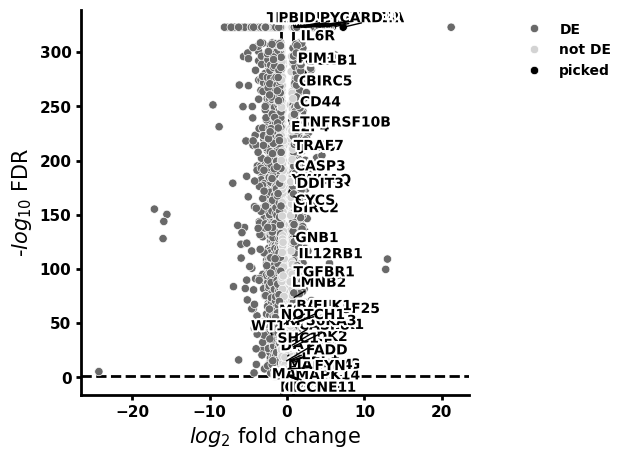

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.77 seconds.

Fitting dispersions...
... done in 4.54 seconds.

Fitting dispersion trend curve...
... done in 0.20 seconds.

Fitting MAP dispersions...
... done in 4.59 seconds.

Fitting LFCs...
... done in 5.19 seconds.

Calculating cook's distance...
... done in 4.54 seconds.

Replacing 289 outlier genes.

Fitting dispersions...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 0.39 seconds.

Fitting LFCs...
... done in 1.68 seconds.

Running Wald tests...
... done in 3.36 seconds.



Log2 fold change & Wald test p-value: Class 1 vs 0
             baseMean  log2FoldChange     lfcSE       stat         pvalue  \
EDF1       193.514972       -0.482188  0.021681 -22.239785  1.416320e-109   
ALDH3A2     15.452914       -0.924448  0.026478 -34.914006  4.557758e-267   
NDUFS5     158.466149       -0.562301  0.025425 -22.116194  2.207896e-108   
ARHGAP30    26.261414        1.739850  0.037576  46.301888   0.000000e+00   
EEF1AKMT4    1.556677       -0.723849  0.087456  -8.276749   1.265840e-16   
...               ...             ...       ...        ...            ...   
CCDC57      23.241942       -1.228683  0.028273 -43.458310   0.000000e+00   
DIP2C       41.766234       -4.814550  0.072250 -66.637312   0.000000e+00   
SPRYD4       5.489782       -0.995609  0.027004 -36.868253  1.491624e-297   
YWHAE      105.158776       -0.332241  0.015653 -21.225517  5.551275e-100   
HLA-DOA     11.479757        2.067888  0.046460  44.509227   0.000000e+00   

                    padj

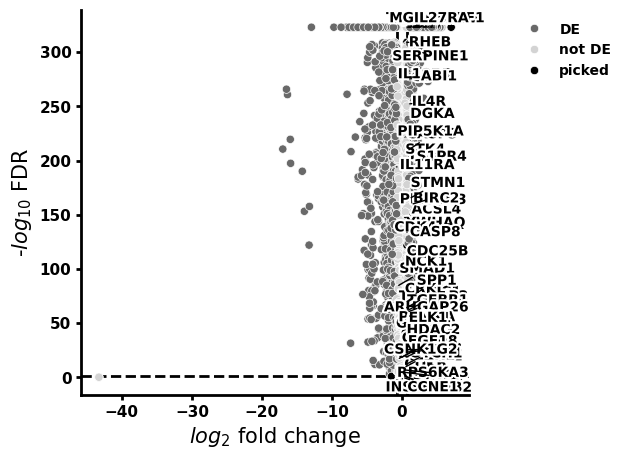

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.69 seconds.

Fitting dispersions...
... done in 4.48 seconds.

Fitting dispersion trend curve...
... done in 0.19 seconds.

Fitting MAP dispersions...
... done in 3.82 seconds.

Fitting LFCs...
... done in 5.96 seconds.

Calculating cook's distance...
... done in 3.54 seconds.

Replacing 307 outlier genes.

Fitting dispersions...
... done in 0.30 seconds.

Fitting MAP dispersions...
... done in 0.40 seconds.

Fitting LFCs...
... done in 2.28 seconds.

Running Wald tests...
... done in 2.72 seconds.



Log2 fold change & Wald test p-value: Class 1 vs 0
             baseMean  log2FoldChange     lfcSE       stat         pvalue  \
EDF1       196.352391       -0.349225  0.020408 -17.112199   1.203691e-65   
ALDH3A2     16.862735       -0.792174  0.027370 -28.943041  3.433379e-184   
NDUFS5     166.562220       -0.536809  0.024946 -21.518928  1.035286e-102   
ARHGAP30    27.954990        2.075840  0.036997  56.108385   0.000000e+00   
EEF1AKMT4    1.586110       -0.970733  0.099181  -9.787539   1.273582e-22   
...               ...             ...       ...        ...            ...   
CCDC57      26.378138       -1.207070  0.031601 -38.197527   0.000000e+00   
DIP2C       45.918952       -5.560056  0.078730 -70.621997   0.000000e+00   
SPRYD4       5.872600       -0.778249  0.025890 -30.059415  1.644725e-198   
YWHAE      118.547731       -0.554913  0.016086 -34.495735  9.294056e-261   
HLA-DOA     14.952045        2.608070  0.049471  52.718926   0.000000e+00   

                    padj

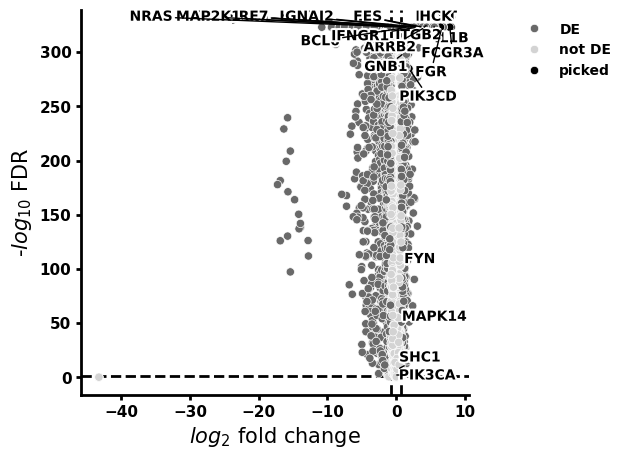

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.75 seconds.

Fitting dispersions...
... done in 4.63 seconds.

Fitting dispersion trend curve...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 4.35 seconds.

Fitting LFCs...
... done in 4.83 seconds.

Calculating cook's distance...
... done in 4.20 seconds.

Replacing 387 outlier genes.

Fitting dispersions...
... done in 0.48 seconds.

Fitting MAP dispersions...
... done in 0.47 seconds.

Fitting LFCs...
... done in 1.64 seconds.

Running Wald tests...
... done in 2.96 seconds.



Log2 fold change & Wald test p-value: Class 1 vs 0
             baseMean  log2FoldChange     lfcSE       stat         pvalue  \
EDF1       148.197401       -0.376270  0.016995 -22.139659  1.312263e-108   
ALDH3A2     10.350335       -0.371529  0.030326 -12.251219   1.654889e-34   
NDUFS5     119.571705       -0.334512  0.020094 -16.647605   3.149580e-62   
ARHGAP30    19.704782        0.397741  0.035322  11.260391   2.058427e-29   
EEF1AKMT4    0.821869        0.095764  0.107738   0.888860   3.740785e-01   
...               ...             ...       ...        ...            ...   
CCDC57      19.722097       -1.185206  0.032867 -36.060484  9.447323e-285   
DIP2C       24.993877       -2.152782  0.089155 -24.146377  8.150524e-129   
SPRYD4       3.907178       -0.642228  0.030136 -21.311236  8.930732e-101   
YWHAE       78.850734       -0.025315  0.018069  -1.400993   1.612163e-01   
HLA-DOA      7.674232        1.731488  0.046262  37.428121  1.363409e-306   

                    padj

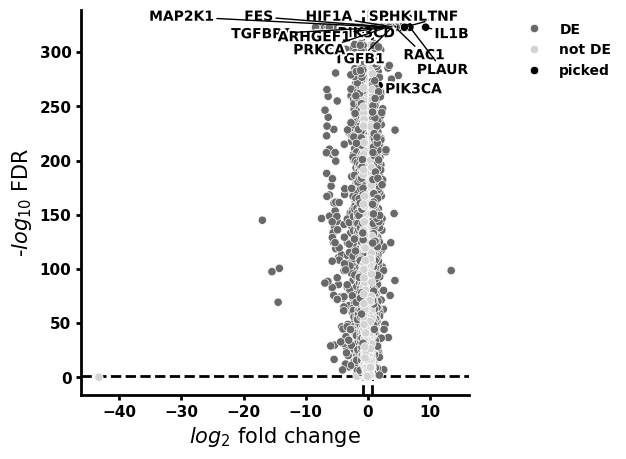

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 1.08 seconds.

Fitting dispersions...
... done in 8.68 seconds.

Fitting dispersion trend curve...
... done in 0.20 seconds.

Fitting MAP dispersions...
... done in 6.81 seconds.

Fitting LFCs...
... done in 5.74 seconds.

Calculating cook's distance...
... done in 5.92 seconds.

Replacing 335 outlier genes.

Fitting dispersions...
... done in 0.44 seconds.

Fitting MAP dispersions...
... done in 0.31 seconds.

Fitting LFCs...
... done in 1.72 seconds.

Running Wald tests...
... done in 3.85 seconds.



Log2 fold change & Wald test p-value: Class 1 vs 0
             baseMean  log2FoldChange     lfcSE       stat         pvalue  \
EDF1       193.997453       -0.479314  0.013731 -34.908344  5.554708e-267   
ALDH3A2     13.361663       -0.624630  0.024878 -25.107399  4.129097e-139   
NDUFS5     164.099789       -0.521603  0.017234 -30.265267  3.285558e-201   
ARHGAP30    23.651582        0.645343  0.032505  19.853528   1.027290e-87   
EEF1AKMT4    1.397878        0.025949  0.089076   0.291312   7.708130e-01   
...               ...             ...       ...        ...            ...   
CCDC57      21.109321        0.141181  0.026087   5.412006   6.232265e-08   
DIP2C       19.827517        1.894682  0.064022  29.594084  1.780573e-192   
SPRYD4       4.983506       -0.623062  0.024306 -25.634364  6.317306e-145   
YWHAE       99.937166       -0.218256  0.014709 -14.838761   8.226125e-50   
HLA-DOA      7.998014        0.490273  0.037932  12.925110   3.248338e-38   

                    padj

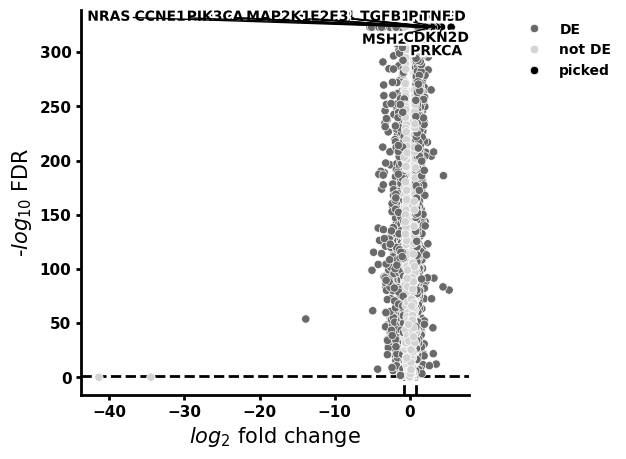

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.74 seconds.

Fitting dispersions...
... done in 4.67 seconds.

Fitting dispersion trend curve...
... done in 0.25 seconds.

Fitting MAP dispersions...
... done in 4.45 seconds.

Fitting LFCs...
... done in 5.75 seconds.

Calculating cook's distance...
... done in 4.59 seconds.

Replacing 306 outlier genes.

Fitting dispersions...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 0.33 seconds.

Fitting LFCs...
... done in 2.50 seconds.

Running Wald tests...
... done in 3.18 seconds.



Log2 fold change & Wald test p-value: Class 1 vs 0
             baseMean  log2FoldChange     lfcSE       stat         pvalue  \
EDF1       233.481107       -0.426983  0.020353 -20.978347   1.034256e-97   
ALDH3A2     20.267134       -0.721904  0.027049 -26.688331  6.429694e-157   
NDUFS5     211.731552       -0.642176  0.024137 -26.605557  5.854016e-156   
ARHGAP30    22.218692        2.727512  0.044470  61.333796   0.000000e+00   
EEF1AKMT4    2.283836       -1.227494  0.111519 -11.007032   3.534572e-28   
...               ...             ...       ...        ...            ...   
CCDC57      25.902154       -0.912870  0.033358 -27.366191  6.930316e-165   
DIP2C       23.347657       -3.973562  0.067585 -58.793446   0.000000e+00   
SPRYD4       7.301426       -0.812245  0.025839 -31.434264  6.888033e-217   
YWHAE      141.017412       -0.523554  0.015070 -34.741990  1.831191e-264   
HLA-DOA     14.540863        3.521688  0.052942  66.519732   0.000000e+00   

                    padj

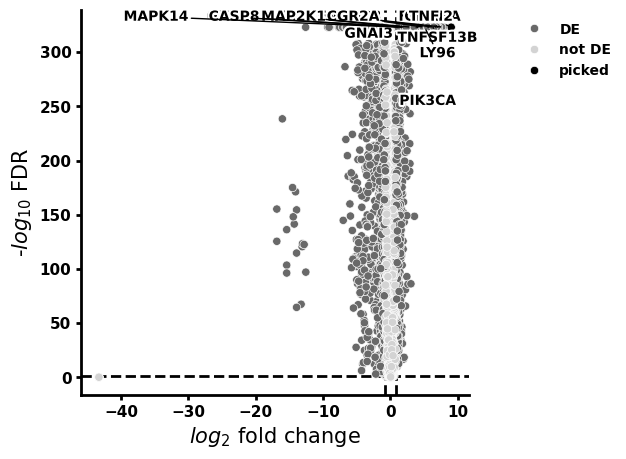

In [20]:
for i in hall_list:
    meta_net = pd.concat([meta_pos[meta_pos['Hallmark'] == i], meta_neg[meta_neg['Hallmark'] == i]])
    data_net = pd.concat([data_pos1[data_pos1.index.isin(meta_net.index)], data_neg1[data_neg1.index.isin(meta_net.index)]])
    inference = DefaultInference(n_cpus=20)
    dds = DeseqDataSet(
        counts=data_net,
        metadata=meta_net,
        design="~Class",
        refit_cooks=True,
        inference=inference,
        n_cpus=20, # n_cpus can be specified here or in the inference object
    )
    dds.deseq2()
    ds = DeseqStats(dds, contrast=["Class", 1, 0], inference=inference)
    ds.summary()
    req_gene = gene_list[i].dropna().to_list()
    volcano(ds.results_df.reset_index(), symbol='index', to_label = req_gene, save='volcano_{}.png'.format(i))